In [17]:
#https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from sklearn.decomposition import PCA

In [18]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [19]:
train.shape

(1458644, 11)

In [20]:
test.shape

(625134, 9)

In [21]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [22]:
print ("No need to worry about missing value") if train.count().min()==train.shape[0] else print(" Missing values present")

No need to worry about missing value


In [23]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [24]:
train.pickup_datetime=pd.to_datetime(train.pickup_datetime)
train.dropoff_datetime=pd.to_datetime(train.dropoff_datetime)
train.loc[:,'pickup_date']=train.pickup_datetime.dt.date
train.store_and_fwd_flag=1*(train.store_and_fwd_flag.values=='Y')

test.pickup_datetime=pd.to_datetime(test.pickup_datetime)
test.loc[:,'pickup_date']=test.pickup_datetime.dt.date
test.store_and_fwd_flag=1*(test.store_and_fwd_flag.values=='Y')

In [25]:
train.check_trip_duration=(train.dropoff_datetime-train.pickup_datetime).map(lambda x:x.total_seconds())
duration_diff=train[np.abs(train.trip_duration.values-train.check_trip_duration.values)>1]
print('Trip duration times are good...') if duration_diff.shape[0]==0 else print('OOps')

Trip duration times are good...


In [26]:
train['trip_duration'].max()//3600

979

In [27]:
train['log_trip_duration']=np.log(train.trip_duration.values+1)

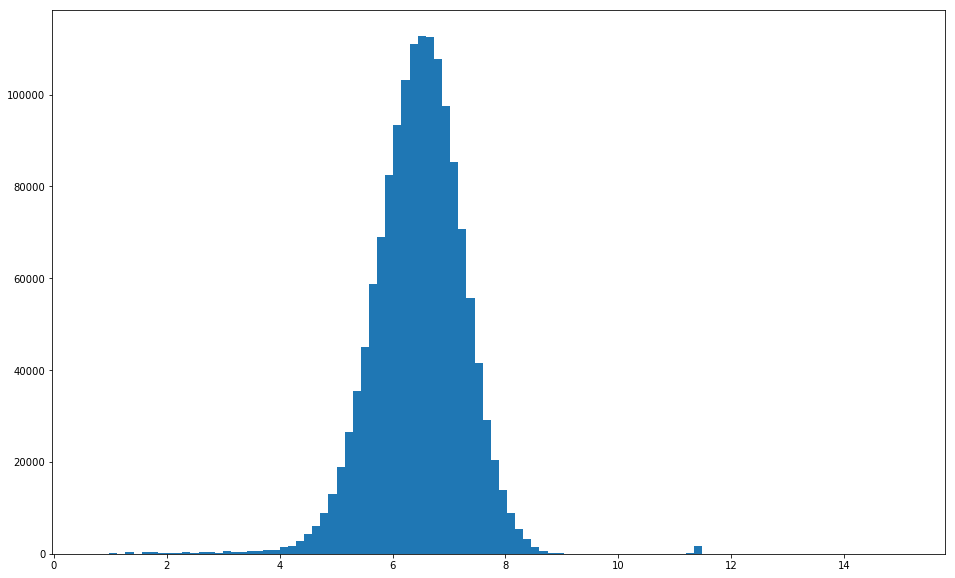

In [28]:
plt.hist(train['log_trip_duration'].values,bins=100)
plt.show()


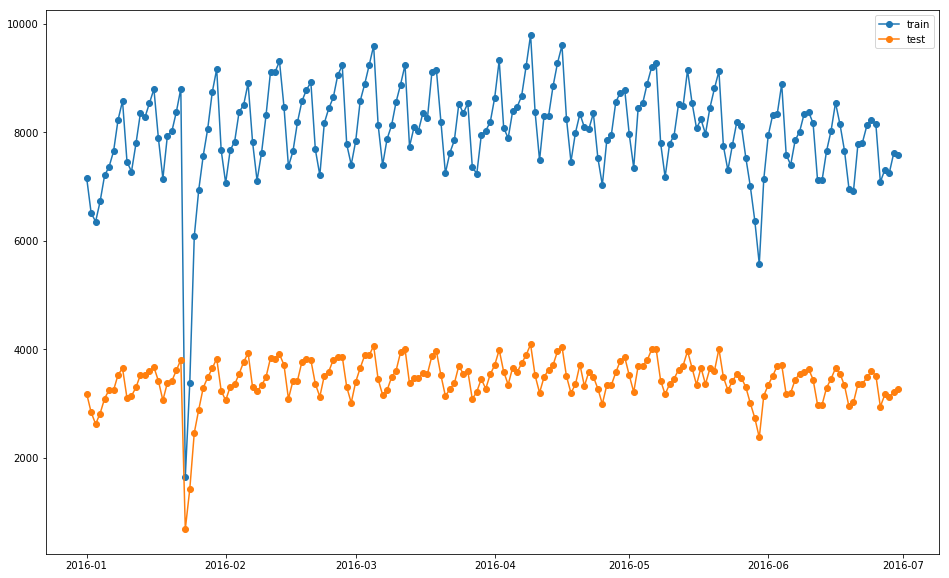

In [29]:
plt.plot(train.groupby('pickup_date').count()['id'],'o-',label='train')
plt.plot(test.groupby('pickup_date').count()['id'],'o-',label='test')
plt.legend(loc=0)
plt.figure(figsize=(5,1))
plt.show()

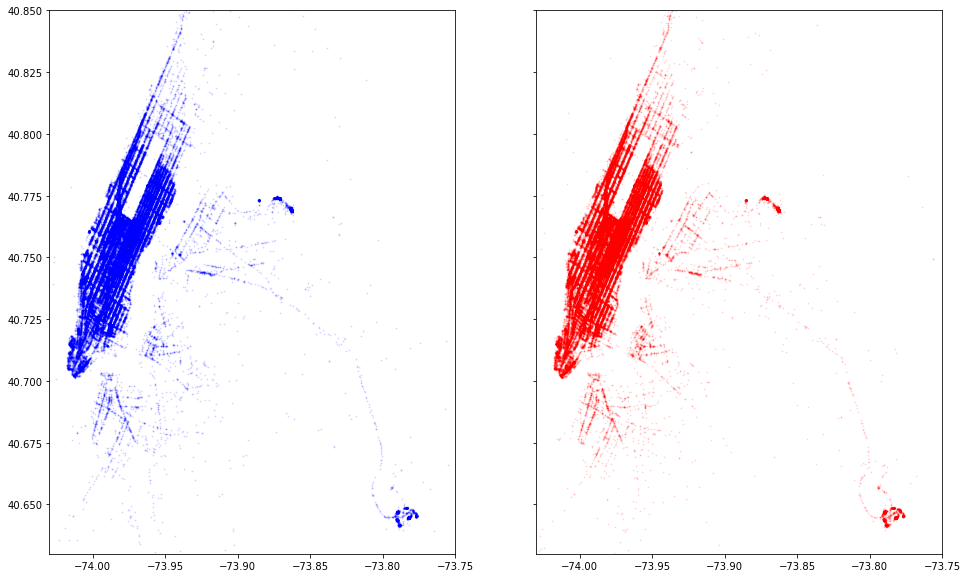

In [30]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig,ax=plt.subplots(ncols=2,sharex=True,sharey=True)
N=100000
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=1,alpha=.1,color='blue',label='train')
ax[1].scatter(test['pickup_longitude'].values[:N],test['pickup_latitude'].values[:N],s=1,alpha=.1,color='red',label='test')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [31]:
#Feature extraction
#PCA
coords=np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                  train[['dropoff_latitude','dropoff_longitude']].values,
                 test[['pickup_latitude','pickup_longitude']].values,
                 test[['dropoff_latitude','dropoff_longitude']].values))
pca=PCA().fit(coords)

train['pickup_pca0']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0]
train['pickup_pca1']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_pca0']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,0]
train['dropoff_pca1']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]


test['pickup_pca0']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_pca1']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_pca0']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]
test['dropoff_pca1']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]

(-0.13426186697746503, 0.1017816834266389)

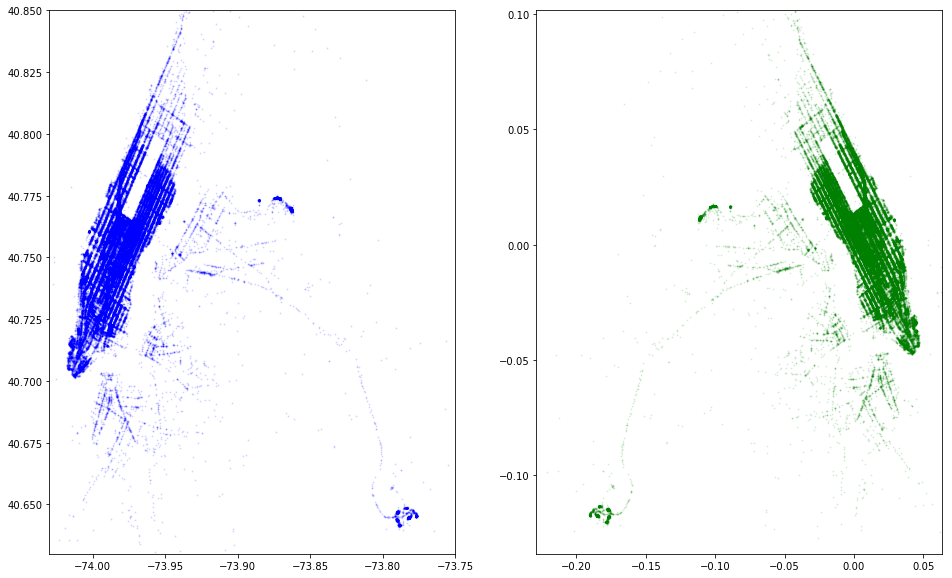

In [41]:
fig,ax=plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=1,alpha=.1,color='blue')
ax[1].scatter(train['pickup_pca0'].values[:N],train['pickup_pca1'].values[:N],s=1,alpha=.1,color='green')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders=pca.transform([[x,y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:,0].min(),pca_borders[:,0].max())
ax[1].set_ylim(pca_borders[:,1].min(),pca_borders[:,1].max())

In [42]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [44]:
train.loc[:,'distance_haversine']=haversine_array(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                                  train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train['distance_haversine']

0           1.498521
1           1.805507
2           6.385098
3           1.485498
4           1.188588
5           1.098942
6           1.326279
7           5.714981
8           1.310353
9           5.121162
10          3.806139
11          3.773096
12          1.859483
13          0.991685
14          6.382836
15          0.656578
16          3.428086
17          2.538672
18          4.605201
19          1.303271
20          2.505926
21          1.724550
22          2.067085
23          4.874792
24         20.602575
25          4.559525
26          6.056109
27          3.738742
28          2.524849
29          9.939443
             ...    
1458614     1.342660
1458615     2.766570
1458616     0.980072
1458617     0.655668
1458618     1.172006
1458619     2.259735
1458620     4.140317
1458621     4.404101
1458622     0.729751
1458623     1.669027
1458624     0.779346
1458625     3.659251
1458626     1.285627
1458627     2.178145
1458628     1.358778
1458629     2.559449
1458630     1